In [5]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(ggsci)
library(ggthemr)

In [13]:
get_cluster<-function(dirs,files,samples,res){
    feat_file=files[[1]]
    meta_file=files[[2]]
    coord_file=files[[3]]
    embed_file==files[[4]]
    cluster_file=files[[5]]
    count=read.csv(feat_file[1],header=T,row.names=1,sep=',')
    meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
    meta=data.frame(batch=meta[,'batch'])
    rownames(meta)=rownames(count)
    coord=read.csv(coord_file[1],header=T,row.names=1,sep=',')
    flags=paste("_",samples[1],sep="")
    for(i in 2:length(samples)){
        a=read.csv(feat_file[i],header=T,row.names=1,sep=',')
        count=rbind(count,a)
        b=data.frame(batch=read.csv(meta_file[i],header=T,row.names=1,sep=',')[,'batch'])
        rownames(b)=rownames(a)
        meta=rbind(meta,b)
        coord=rbind(coord,read.csv(coord_file[i],header=T,row.names=1,sep=','))
        flags=paste(flags,"_",samples[i],sep="")
    }
    count=as(as.matrix(t(count)),'dgCMatrix')
    obj<-CreateSeuratObject(counts=count,min.cells=0, min.features=0,meta.data=meta)
    VariableFeatures(obj)<-rownames(obj)
    obj@assays$RNA@scale.data=as.matrix(count)
    obj<-ScaleData(obj)
    obj<-RunPCA(obj,npcs=50)
    obj<-RunUMAP(obj,reduction='pca',dims=1:50)
    obj@images$image <- new(
        Class = 'SlideSeq',
        assay = "Spatial",
        key = "image_",
        coordinates = coord
     )
    embed=read.csv(embed_file,header=T,row.names=1)
    znoise_dim=1
    if(dim(embed)[2]==16){
        znoise_dim=3}else{
        znoise_dim=5
    }
    embed=embed[colnames(obj),znoise_dim:dim(embed)[2]]
    obj[['spiral']]<-CreateDimReducObject(embeddings=as.matrix(embed), key = "spiral_", assay = DefaultAssay(obj))
    obj <-RunUMAP(obj, reduction = "spiral",dims=1:dim(embed)[2],reduction.name="spiral.umap")
    obj<-FindNeighbors(obj, dims=1:dim(embed)[2],reduction='spiral')
    obj<-FindClusters(obj, resolution = res)
    write.csv(as.data.frame(obj$seurat_clusters),cluster_file)
    return(obj)
}


mouse OB

In [14]:

#####set res make there are 9 clusters#######
res=0.5
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
extra_dirs="BGI_SlideV2_10X/"
path=paste(dirs,'gtt_input/',extra_dirs,sep="")

samples=c("BGI","SlideV2")
feat_file=paste(path,samples[1],"_mat.csv",sep="")
meta_file=paste(path,samples[1],"_meta.csv",sep="")
coord_file=paste(path,samples[1],"_coord.csv",sep="")
flags=paste("_",samples[1],sep="")
for(i in 2:length(samples)){
    feat_file=c(feat_file,paste(path,samples[i],"_mat.csv",sep=""))
    meta_file=c(meta_file,paste(path,samples[i],"_meta.csv",sep=""))
    coord_file=c(coord_file,paste(path,samples[i],"_coord.csv",sep=""))
    flags=paste(flags,"_",samples[i],sep="")
}
embed_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent_512.csv",sep="")
# embed_file=paste(dirs,"gtt_output/SPIRAL_pyg",flags,"_embed_512",".csv",sep="")
cluster_file=paste(dirs,'metrics/spiral',flags,'_seuratmethod_clust_modify.csv',sep="")
files=list(feat_file,meta_file,coord_file,embed_file,cluster_file)
obj=get_cluster(dirs,files,samples,res)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Centering and scaling data matrix

PC_ 1 
Positive:  Nme7, Cmss1, Nrxn3, Trhde, Cadm2, Ptprd, Celf2, Galntl6, Dlg2, Lrp1b 
	   Auts2, Kcnd2, Il1rapl1, Atp2b1, Gm15564, Dlgap1, Cntnap2, Syt1, Nrxn1, Opcml 
	   Shank1, Gad1, Pde4d, Pbx1, Pcdh15, Ank3, Gm10800, Eef1a1, Fam155a, Anks1b 
Negative:  Atf5, Omp, Rpl4, Timp3, Stoml3, Doc2g, S100a5, Tomm40l, X1700012B09Rik, Acadvl 
	   Spidr, Schip1, Ifi27, Stmn1, Yjefn3, Rbp1, Becn1, Scgb1c1, Aimp2, Lrrc24 
	   Rps4x, Bst2, Ccdc167, Sult1a1, Rps8, Ifitm3, Cbr2, Bpifa1, Cyp2a5, Ppia 
PC_ 2 
Positive:  Atp1a2, S100a5, Gm10800, Ptn, Gng13, Cmss1, Vtn, Ptprd, Apod, Fabp7 
	   Kctd12, Nme7, Shank1, Hbb.bs, Kirrel3, Zbtb20, Sntb1, Syn3, Trhde, Rora 
	   Nr2f2, Wwox, Hbb.bt, Gpc6, Pcdh15, Sash1, Kcnip4, Npy, Naaladl2, Hba.a2 
Negative:  Pcp4, Tuba1a, Calm2, Camk2n1, Ncdn, Pcp4l1, Camk2b, Gng4, Nsg2, Gpsm1 
	   Atp1b1, Penk, Tubb2a, Ubb, Eno2, Pnmal2, Dynll

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27364
Number of edges: 856007

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8448
Number of communities: 13
Elapsed time: 6 seconds


4 singletons identified. 9 final clusters.



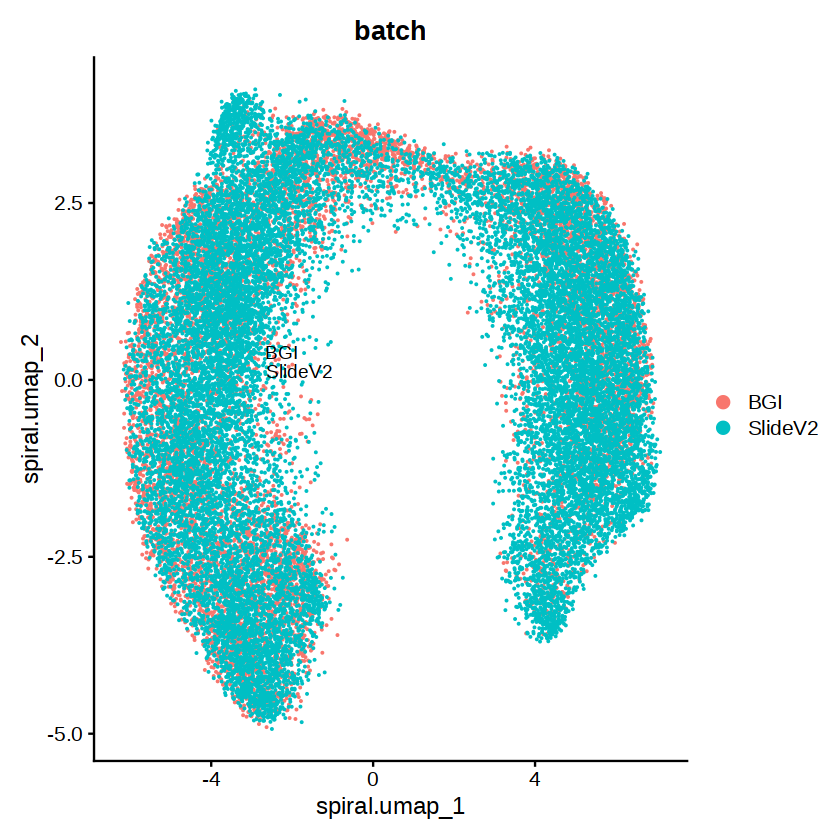

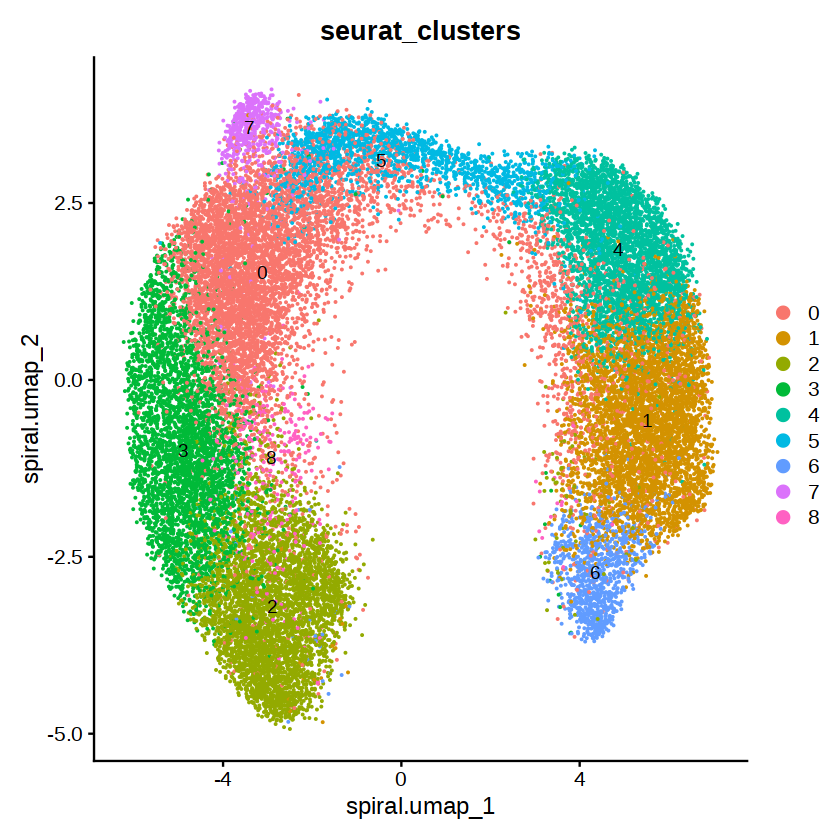

In [15]:
DimPlot(obj,group.by="batch",label=T,reduction="spiral.umap")
DimPlot(obj,group.by="seurat_clusters",label=T,reduction="spiral.umap")

coronal mouse brain

In [17]:
############
res=1.0
dirs="/data02/tguo/space_batch_effect/Hippo/"
path=paste(dirs,'gtt_input/',sep="")
samples=c("10X_Normal","10X_DAPI","10X_FFPE")
feat_file=paste(path,samples[1],"_mat.csv",sep="")
meta_file=paste(path,samples[1],"_meta.csv",sep="")
coord_file=paste(path,samples[1],"_coord.csv",sep="")
flags=paste("_",samples[1],sep="")
for(i in 2:length(samples)){
    feat_file=c(feat_file,paste(path,samples[i],"_mat.csv",sep=""))
    meta_file=c(meta_file,paste(path,samples[i],"_meta.csv",sep=""))
    coord_file=c(coord_file,paste(path,samples[i],"_coord.csv",sep=""))
    flags=paste(flags,"_",samples[i],sep="")
}
embed_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent_256.csv",sep="")
# embed_file=paste(dirs,"gtt_output/SPIRAL_pyg",flags,"_embed_256",".csv",sep="")
cluster_file=paste(dirs,'metrics/spiral',flags,'_seuratmethod_clust_modify.csv',sep="")
files=list(feat_file,meta_file,coord_file,embed_file,cluster_file)
obj=get_cluster(dirs,files,samples,res)

Centering and scaling data matrix

PC_ 1 
Positive:  Gapdh, Ubb, Chchd2, Tuba1b, Cd63, H3f3a, Atp5g1, Gng5, Snrpn, Ptgds 
	   Ndufb4, Chchd10, Atp5f1, Eef1a1, Atp5l, Pebp1, Stmn1, Cycs, Uqcrb, Cox7b 
	   Hint1, Fth1, Ctsd, Actb, Hbb.bs, Gsn, Dbi, Hbb.bt, Cers2, Ifi27 
Negative:  Sept5, Syngap1, Syp, Gpm6a, Nell2, Pcdhgc5, Ptprn2, Clstn1, Olfm1, Kalrn 
	   Chn1, Camk2b, Kctd16, Snap25, Cadm3, Grin1, Prrt2, Slc17a7, Eno2, Gabrb2 
	   Camk4, Pfn2, Camk2n1, Egr1, Ywhaz, Gabrb3, Atp1b1, Arpp21, Prkar1b, Cacng8 
PC_ 2 
Positive:  Nrgn, Dynll1, Ttc9b, Ppp3r1, Calm2, Atpif1, Syn2, X1110008P14Rik, Ndufb4, Gapdh 
	   Pebp1, Snrpn, Stx1a, Tuba4a, Rab3a, Ubb, Fbxl16, Nme1, Timm8b, Chchd2 
	   Ensa, Calm1, Rab6a, Atp6v0c, Nptxr, Atp5g1, Cycs, Cnih2, Ids, Atp5f1 
Negative:  Plekhb1, Mobp, Mbp, Gatm, Cnp, Apod, Trf, Plp1, Csrp1, Qk 
	   Slc6a11, Mag, Tspan2, Car2, Kcnj10, Qdpr, Bcas1, Slc6a9, Mal, Cldn11 
	   Atp1a2, Sept4, Cryab, Mog, Nfasc, Plekhg1, Pacs2, Phldb1, Fa2h, Gpr37 
PC_ 3 
Positive:  Lbp

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7869
Number of edges: 326028

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8807
Number of communities: 23
Elapsed time: 1 seconds


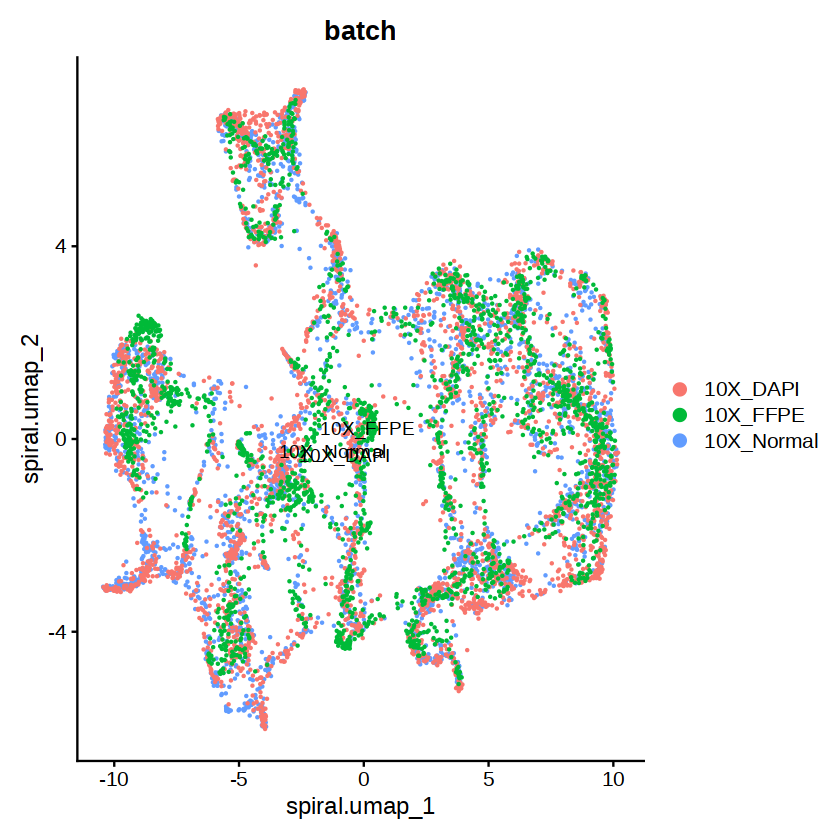

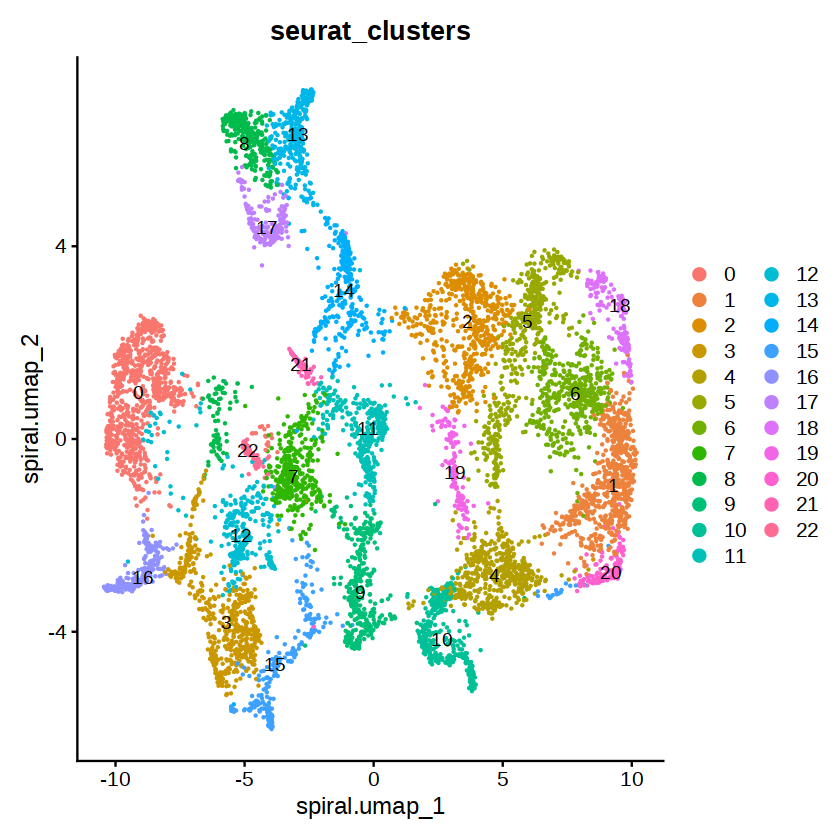

In [18]:
DimPlot(obj,group.by="batch",label=T,reduction="spiral.umap")
DimPlot(obj,group.by="seurat_clusters",label=T,reduction="spiral.umap")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from spiral.umap_ to spiralumap_”
Warning message:
“Adding image data that isn't associated with any assay present”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 802
Number of edges: 30726

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8351
Number of communities: 4
Elapsed time: 0 seconds


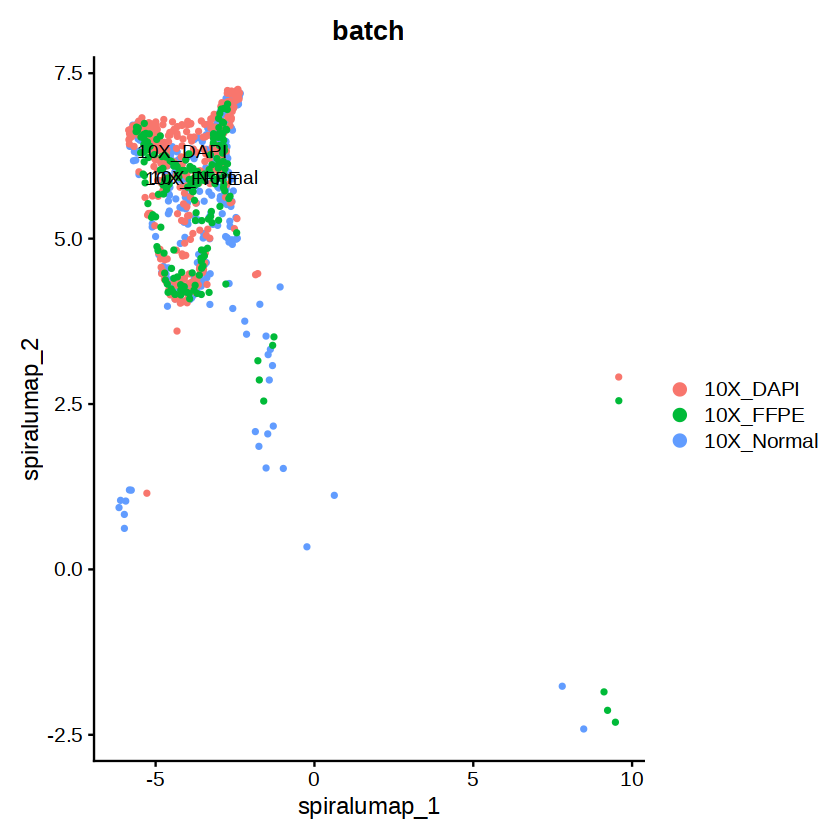

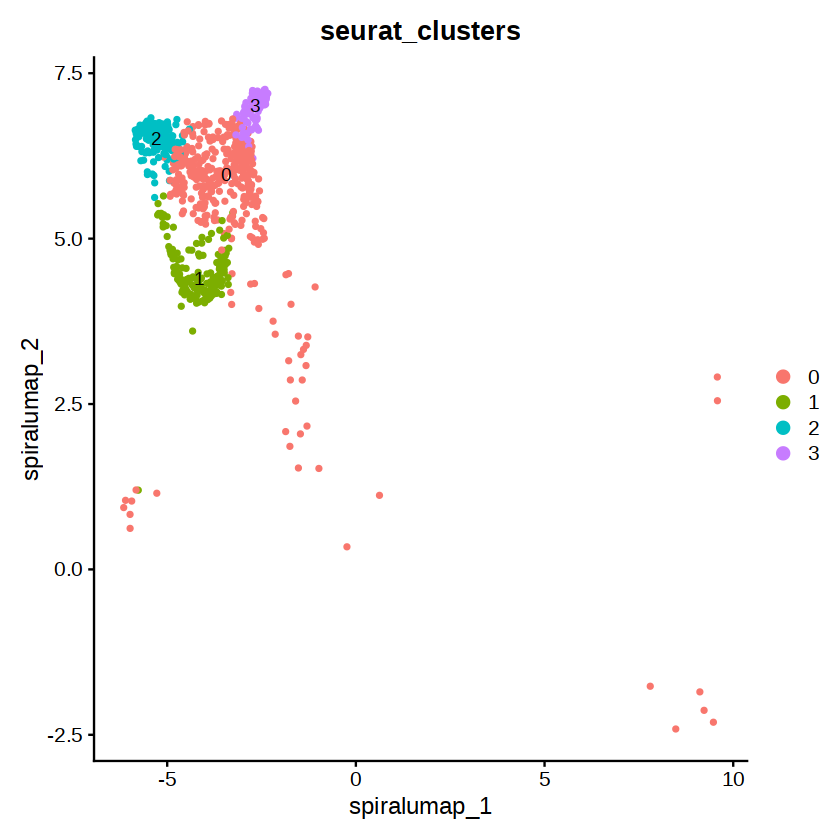

In [28]:
#######hippo region#########
meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
for(i in 2:length(samples)){
    meta=rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
}
obj$celltype=meta[colnames(obj),'celltype']

obj.hippo<-subset(obj,subset=celltype%in%c('Hippocampus','CA1/2','CA3','DG'))
obj.hippo<-FindNeighbors(obj.hippo, dims=1:28,reduction='spiral')
obj.hippo<-FindClusters(obj.hippo, resolution = 0.3)
DimPlot(obj.hippo,group.by="batch",label=T,reduction="spiral.umap")
DimPlot(obj.hippo,group.by="seurat_clusters",label=T,reduction="spiral.umap")# write.csv(as.data.frame(obj.hippo$seurat_clusters),paste(dirs,'metrics/',method,flags,'_hippo_seuratmethod_clust_modify.csv',sep=""))

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



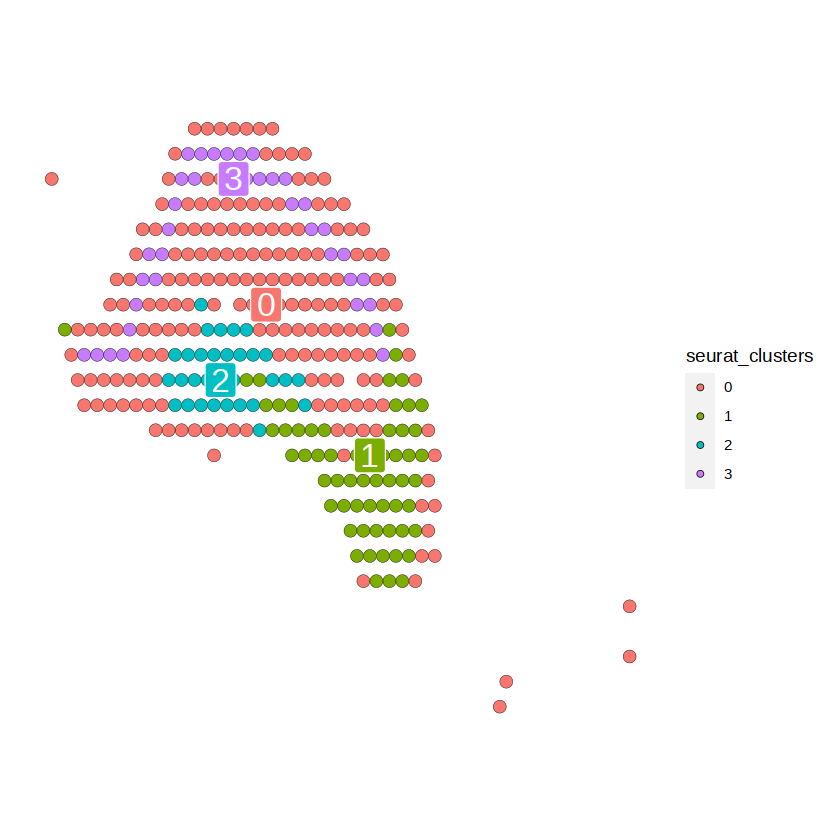

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



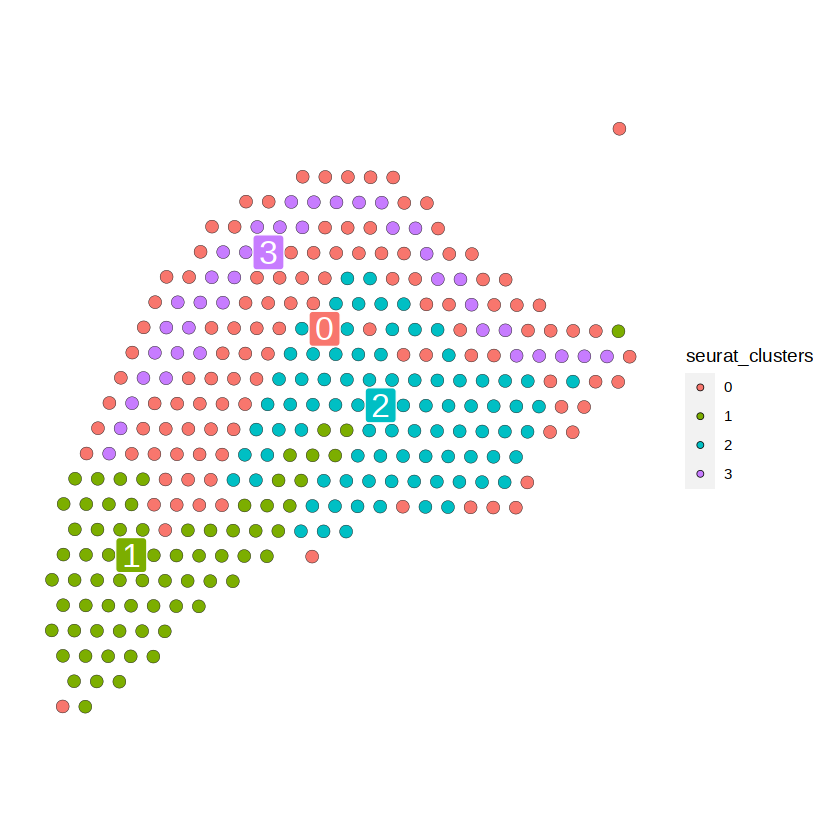

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



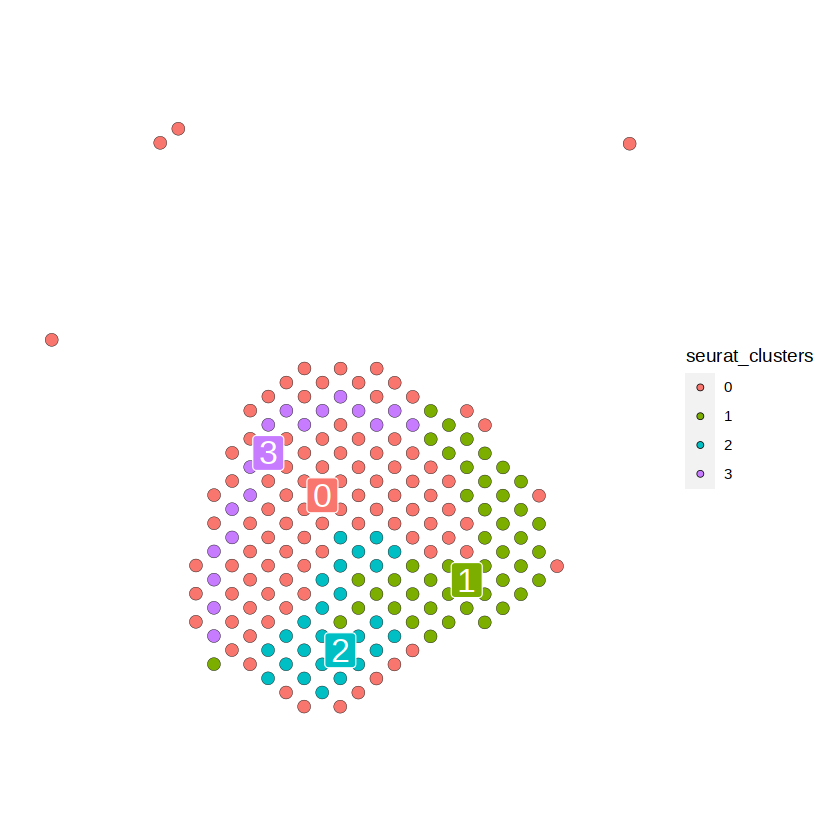

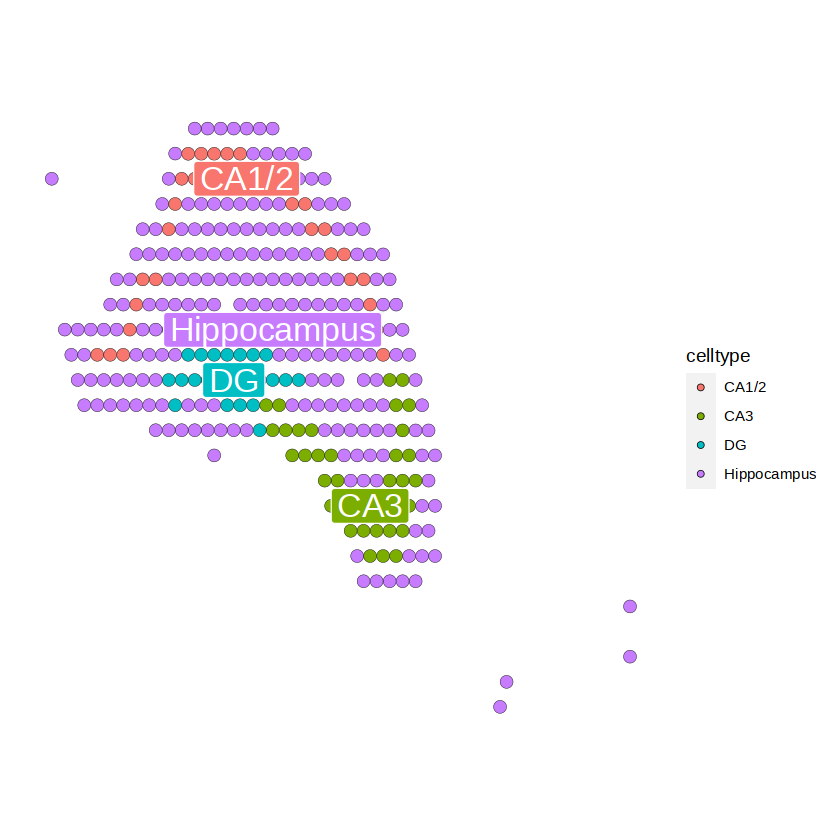

In [29]:
ub=unique(obj.hippo$batch)
obj1=subset(obj.hippo,subset=batch==ub[1])
obj2=subset(obj.hippo,subset=batch==ub[2])
obj3=subset(obj.hippo,subset=batch==ub[3])
s1=5
s2=5
s3=5
SpatialDimPlot(obj1,group.by="seurat_clusters",label=T,pt.size=s1)
SpatialDimPlot(obj2,group.by="seurat_clusters",label=T,pt.size=s2)
SpatialDimPlot(obj3,group.by="seurat_clusters",label=T,pt.size=s3)
SpatialDimPlot(obj1,group.by="celltype",label=T,pt.size=s1)